## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization
def build_mlp(input_shape,output_units=10,num_neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,activation='relu',name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,activation='relu',name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units,activation='softmax',name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    
    return model

In [14]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath='./tmp.h5',monitor='val_loss',save_best_only=False)
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE,nesterov=True,momentum=MOMENTUM)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)

model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=(x_test,y_test),shuffle=True,callbacks=[model_ckpt])

train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

model = keras.models.load_model('./tmp.h5')
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 26s 514us/step - loss: 0.4970 - acc: 0.8598 - val_loss: 1.6545 - val_acc: 0.4880
Epoch 50/50
10000/10000 [==============================] - 7s 673us/step


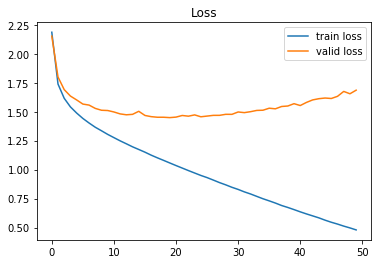

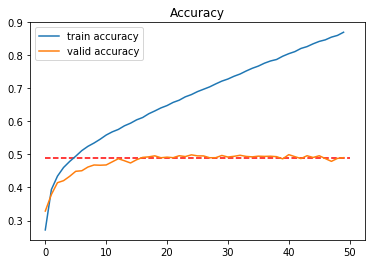

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.plot(y=loss_loadback,xmin=0,xmax=len(train_loss),colors='r',linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()